In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
import pickle
import cv2
import urllib.request
from google.colab.patches import cv2_imshow

# Loading the bear image

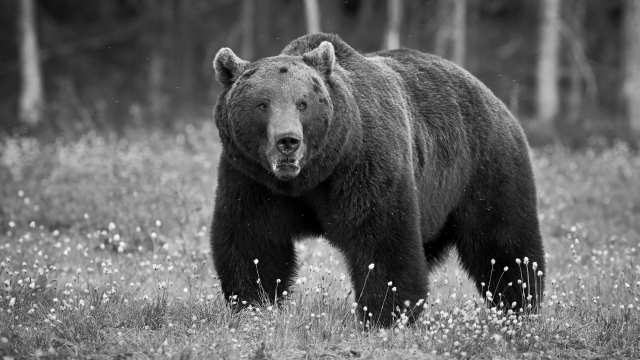

The shape of the bear image is : (360, 640)


In [5]:
tf.random.set_seed(100)
url = "https://ewscripps.brightspotcdn.com/dims4/default/e666c4b/2147483647/strip/true/crop/1280x720+0+0/resize/1280x720!/quality/90/?url=https%3A%2F%2Fewscripps.brightspotcdn.com%2Fb0%2F82%2Fe97f14ff421ca8ca7d8692e0ecdb%2Fgeneric-1280-1.png"
urllib.request.urlretrieve(url, "bear.png")
bear = cv2.imread("bear.png")
bear = cv2.resize(bear, None, fx=0.5, fy=0.5)
bw_bear = cv2.cvtColor(bear, cv2.COLOR_BGR2GRAY)
bear_edges = np.zeros(bw_bear.shape)
cv2_imshow(bw_bear)
bw_bear = tf.convert_to_tensor(bw_bear, dtype = tf.float32)
print("The shape of the bear image is : {}".format(bw_bear.shape))

# Question 1 - Padding and Stride (20 points)

In class, you all learnt about the cross-correlation operation and creating a Convolutional layer through layer subclassing. For this question, you will be asked to create a convolutional layer with padding and stride

## Part (a) Cross-correlation with Stride (10 points)

Similar to lecture, implement the following cross-correlation operations with a stride argument using only basic tensorflow operations (no keras operations or tensorflow.nn operations)

In [2]:
#############################################################################
# TODO:                                                                     #
# Implement cross-correlation with stride                                   #
# Input: X of shape (h_x, w_x), K of shape (h_k, w_k), s is a 2-tuple       #
#        indicating vertical  and horizontal stride                         #
# ONLY use tensorflow for this section! Use of keras/tf.nn will give you    #
# 0 points                                                                  #
#############################################################################


def conv2dwithstride(X, K, s):
    # Expand dimensions of X and K to match conv2d function requirements
    X = tf.expand_dims(tf.expand_dims(X, axis=0), axis=-1)
    K = tf.expand_dims(tf.expand_dims(K, axis=-1), axis=-1)

    # Define strides tensor
    strides = [1, s[0], s[1], 1]

    # Perform convolution
    conv_result = tf.nn.conv2d(X, K, strides=strides, padding='VALID')

    # Squeeze the output tensor to remove extra dimensions
    return tf.squeeze(conv_result)


### Test cases

The cross-correlation operation is very useful in image processing. With the right kernel, you can perform edge detection, blurring, bokeh effects, etc.

In [3]:
blurr_kernel = tf.Variable(
    [[1, 4, 7, 4, 1],
     [4, 16, 26, 16, 4],
     [7, 26, 41, 26, 7],
     [4, 16, 26, 16, 4],
     [1, 4, 7, 4, 1]], dtype = tf.float32)/273
edge_kernel = tf.Variable([[-1,-1,-1], [-1,8,-1], [-1,-1,-1]], dtype = tf.float32)

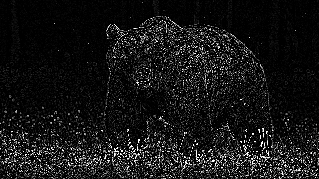

(179, 319)


In [6]:
bw_bear_edge = conv2dwithstride(bw_bear, edge_kernel, (2, 2))
cv2_imshow(bw_bear_edge.numpy())
print(bw_bear_edge.shape)

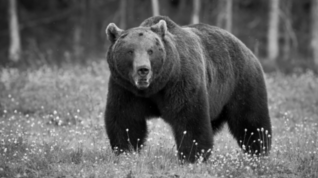

(178, 318)


In [7]:
bw_bear_blur = conv2dwithstride(bw_bear, blurr_kernel, (2, 2))
cv2_imshow(bw_bear_blur.numpy())
print(bw_bear_blur.shape)

## Part (b) Convolutional layer with Padding and Stride (10 points)

Fill in the following class to create a convolutional layer with Padding and stride using the function from Part (a). Implement this without the bias term. If padding $p$ is even, you can pad either sides with $p/2$ rows/columns. If your padding for the rows is odd, you can pad the top with $\lfloor p/2 \rfloor$ rows and the bottom with $\lceil p/2 \rceil$. Similarly, in the case of odd padding for columns, you can pad the left with $\lfloor p/2 \rfloor$ columns and the right with $\lceil p/2 \rceil$ columns. Please remember to set ```initializer = tf.random_normal_initializer(seed=100)``` to make your results reproducible

In [11]:
#############################################################################
# TODO:                                                                     #
# Fill in the Conv2DwithStridePadding class                                 #
#############################################################################


class Conv2DwithStridePadding(tf.keras.layers.Layer):
#############################################################################
# Inputs: kernel_size is 2-tuple - (h_k, w_k),                              #
#         stride is 2-tuple indicating vertical  and horizontal stride.     #
#                 respectively                                              #
#         padding is 2-tuple indicating padding for rows and columns        #
#                 respectively                                              #
#############################################################################
    def __init__(self, kernel_size, stride, padding):
        super(Conv2DwithStridePadding, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        # Initialize the kernel as a trainable weight
        self.kernel = self.add_weight(
            "kernel",
            shape=(kernel_size[0], kernel_size[1], 1, 1),
            initializer="random_normal",
            trainable=True
        )

    #############################################################################
    # Inputs: X of shape (h_x, w_x)                                             #
    #############################################################################
    def call(self, inputs):
         # Expand dimensions of input to match the expected format by conv2d
        inputs = tf.expand_dims(inputs, axis=0)  # add batch dimension
        inputs = tf.expand_dims(inputs, axis=-1)  # add channel dimension

        # Correct padding to include batch and channel dimensions
        pad_top, pad_bottom, pad_left, pad_right = self.padding[0], self.padding[0], self.padding[1], self.padding[1]
        paddings = tf.constant([[0, 0], [pad_top, pad_bottom], [pad_left, pad_right], [0, 0]])

        # Apply padding if specified
        inputs = tf.pad(inputs, paddings, mode='CONSTANT', constant_values=0)

        # Perform the convolution using the kernel
        output = tf.nn.conv2d(
            inputs,
            self.kernel,
            strides=[1, self.stride[0], self.stride[1], 1],
            padding="VALID"
        )

        # Remove the last dimension added for channel to match the expected output dimension
        output = tf.squeeze(output, axis=-1)
        return output


### Test Cases

In [12]:
convlayer = Conv2DwithStridePadding((3, 3), (2, 2), (2, 2))
X = tf.ones((32, 32))
Y = convlayer(X)
print(Y[0])
print(Y.shape)

tf.Tensor(
[[-0.10048576 -0.15887089 -0.15887089 -0.15887089 -0.15887089 -0.15887089
  -0.15887089 -0.15887089 -0.15887089 -0.15887089 -0.15887089 -0.15887089
  -0.15887089 -0.15887089 -0.15887089 -0.15887089 -0.05838513]
 [-0.03303622 -0.07302107 -0.07302107 -0.07302107 -0.07302107 -0.07302107
  -0.07302107 -0.07302107 -0.07302107 -0.07302107 -0.07302107 -0.07302107
  -0.07302107 -0.07302107 -0.07302107 -0.07302107 -0.03998485]
 [-0.03303622 -0.07302107 -0.07302107 -0.07302107 -0.07302107 -0.07302107
  -0.07302107 -0.07302107 -0.07302107 -0.07302107 -0.07302107 -0.07302107
  -0.07302107 -0.07302107 -0.07302107 -0.07302107 -0.03998485]
 [-0.03303622 -0.07302107 -0.07302107 -0.07302107 -0.07302107 -0.07302107
  -0.07302107 -0.07302107 -0.07302107 -0.07302107 -0.07302107 -0.07302107
  -0.07302107 -0.07302107 -0.07302107 -0.07302107 -0.03998485]
 [-0.03303622 -0.07302107 -0.07302107 -0.07302107 -0.07302107 -0.07302107
  -0.07302107 -0.07302107 -0.07302107 -0.07302107 -0.07302107 -0.073021

# Question 2 - Mystery block implementation - (15 points)



An important aspect of deep learning is to convert a conceptual idea of neural network or a neural architecture into code. This motivates the idea of blocks. Many neural network models use many blocks (which are a collection of layers) to build the neural network. Let's further explore this idea.

---

Suppose we want to implement the following block

<img src='https://drive.google.com/uc?id=1Eu6XK96JwDJA0r_qBDkmpU5IihSJQYja' width = 700>

I would write the following code to implement this block. And this block can be used a building blocks for a complex neural network.

In [13]:
class ExampleBlock(keras.Model):
  def __init__(self):
    super(ExampleBlock, self).__init__()
    self.dense1 = layers.Dense(64, activation='relu',
                               kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=100))
    self.dense2 = layers.Dense(64, activation = "relu",
                               kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=100))

  def call(self, x):
    weighted_x = self.dense1(x)
    weighted_x = self.dense2(weighted_x)
    return weighted_x

In [14]:
blk = ExampleBlock()
X = tf.random.normal((1, 32, 32, 3))
Y = blk(X)
Y.shape

TensorShape([1, 32, 32, 64])

Similar to the example, fill in ```__init__()``` and ```call()``` using the following flowchart to implement MysteryBlock class

<img src='https://drive.google.com/uc?id=1LoZjHA92C2Lk14y0pSHi5RqeY47otBB4' width = 700>

Please remember to set ```kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=100)``` in your Convolutional layers and dense layers to make the results reproducible. Also remember to set ```padding = "same"```

In [33]:
class MysteryBlock(Model):
    def __init__(self):
        super(MysteryBlock, self).__init__()
        # Define the layers based on the standard flow
        self.conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.maxpool1 = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')
        self.conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.maxpool2 = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(1024, activation='relu')
        self.dense2 = layers.Dense(10)

    def call(self, x):
        # Forward pass through the convolutional and pooling layers
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        # Forward pass through the flatten and dense layers
        x = self.flatten(x)
        x = self.dense1(x)
        # Pass through the output layer
        return self.dense2(x)



### Test cases

In [34]:
tf.random.set_seed(100)
block = MysteryBlock()
X = np.ones((1, 32, 32, 3))
Y = block(X)
print(tf.shape(Y))
print(Y)

tf.Tensor([ 1 10], shape=(2,), dtype=int32)
tf.Tensor(
[[-4.8749405e-01  1.1516303e-01 -6.0049720e-02 -5.1309176e-02
   1.7760919e-01 -1.6127343e-01  3.6021206e-01  3.9790511e-02
   2.8787553e-04  6.6071928e-01]], shape=(1, 10), dtype=float32)


# Question 3 - Residual Block Implementation (15 points)


Similarly, using the following flowchart, fill in the ```__init__()``` and ```call()``` for the ResidualBlock class

<img src='https://drive.google.com/uc?id=1P5nKQUh3IA-yGFScOtt9oJb9pTTmB3rC' width = 700>

The left flowchart is the ResidualBlock Architecture for when ``` self_conv = False ``` and the right flowchart is when ```self_conv = True```. ```filters``` is a list of filters for the respective convolutional layers.


In the flowchart, we can see a batch normalization layer. This layer is added to make training faster and more stable by recentering and rescaling the network inputs.

Please remember to set ```kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=100)``` in your Convolutional layers to make the results reproducible.

In [48]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class ResidualBlock(keras.Model):
    def __init__(self, filters, self_conv):
        super(ResidualBlock, self).__init__()
        F1, F2 = filters[:2]
        self.self_conv = self_conv

        # First conv layer
        self.conv1 = layers.Conv2D(F1, kernel_size=(3, 3), padding='same', strides=(1 if not self_conv else 2))
        self.bn1 = layers.BatchNormalization()

        # Second conv layer
        self.conv2 = layers.Conv2D(F2, kernel_size=(3, 3), padding='same')
        self.bn2 = layers.BatchNormalization()

        # Additional 1x1 conv layer if self_conv is True
        if self_conv:
            self.conv3 = layers.Conv2D(F2, kernel_size=(1, 1), strides=2)
            self.bn3 = layers.BatchNormalization()

    def call(self, x):
        # Save the input value for the shortcut connection
        shortcut = x

        # First conv layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = tf.nn.relu(x)

        # Second conv layer
        x = self.conv2(x)
        x = self.bn2(x)

        # If self_conv is True, apply the conv3 layer to the shortcut
        if self.self_conv:
            shortcut = self.conv3(shortcut)
            shortcut = self.bn3(shortcut)

        # Add the shortcut to the output of the second conv layer
        x = layers.add([x, shortcut])
        x = tf.nn.relu(x)

        return x



### Test Cases

In [50]:
tf.random.set_seed(100)
X = np.ones((1, 32, 32, 3))
block_2 = ResidualBlock([16, 3], False)
Y_2 = block_2(X)
print(tf.shape(Y_2))
print(Y_2[0, 0, 0])

block_3 = ResidualBlock([16, 3, 3], True)
Y_3 = block_3(X)
print(tf.shape(Y_3))
print(Y_3[0, 0, 0])

tf.Tensor([ 1 32 32  3], shape=(4,), dtype=int32)
tf.Tensor([1.0505275  1.3432662  0.85455054], shape=(3,), dtype=float32)
tf.Tensor([ 1 16 16  3], shape=(4,), dtype=int32)
tf.Tensor([0.        0.        0.7082117], shape=(3,), dtype=float32)


# Question 4 - ResNet18 Implmentation (30 points)

ResNet or Residual Network is a very popular Convolutional Neural network. It uses the concept of skip connections (as seen in Question 2) which adds the input with the output when the input goes through a bunch of convolutonal layers. This addition is key when some of the higher layers don't produce anything meaningful, the lower layers in the architechture still have a chance to perform well with the input. So, say the input passes through some convolutional layers and the output is 0. By adding the input back, we are giving the next convolutional layers some meaningful input.

In this question, you will be asked to build ResNet18 which contains 18 convolutonal layers in total. You will be using the Cifar10 dataset to train the model. This dataset contains 60,000 32*32 color images (so it has 3 channels). These are the classes in the dataset - airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.

In [51]:
from keras.datasets import cifar10
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

(X_train_old, Y_train_old), (X_test_old, Y_test_old) = cifar10.load_data()

In [52]:
X_train = X_train_old.astype('float32')
X_test = X_test_old.astype('float32')
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train_old, test_size=0.2, random_state=42)

encoder = OneHotEncoder()
encoder.fit(Y_train_old)
Y_train = encoder.transform(y_train).toarray()
Y_val = encoder.transform(y_val).toarray()
Y_test = encoder.transform(Y_test_old).toarray()

print(X_train.shape)
print(Y_train.shape)

(40000, 32, 32, 3)
(40000, 10)


## Part (a) Data Augmentation (10 points)

Before starting to train the ResNet Model, we need to make some modifications to our images. Data Augmentation is a great way to prevent overfitting. We also need to rescale the model to have the pixels be between 0 and 1. Create a sequential model that has 3 layers - a layer that does random horizontal flips, a layer that does random rotations of factor 0.2, and a layer that rescales the images accordingly.

Please remember to set the seed argument to 100 for the Random layers.

In [54]:
data_aug_preprocess = tf.keras.Sequential([
  layers.RandomFlip("horizontal", seed=100),
  layers.RandomRotation(0.2, seed=100),
  layers.Rescaling(1./255)
])

## Part (b) Filling in ResNet18 Class (20 points)
Use the following flowchart and ResidualBlock class from Question 3 to implement ResNet18

<img src='https://drive.google.com/uc?id=1y6DHU48iu54YAeg7ywx7_3zyZKHnbsdY' width = 800>

The "Skip Connection" parts are the ResidualBlocks where ```self_conv = True```. This flowchart doesn't include the output layer. Please remember to include an appropriate output layer for an image classification problem. ```data_aug``` will take the sequential model with the data augmentation and preprocessing layers

Please remember to set ```kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=100)``` in your Convolutional layers and dense layers to make the results reproducible.

Make sure to go to "Edit" > "Notebook Settings" and select "GPU" before running the next few code chunks.


In [71]:
class ResNet18(keras.Model):
    def __init__(self, num_classes, input_shape, data_aug):
        super(ResNet18, self).__init__()
        self.da = data_aug  # Use the data_aug argument passed to the constructor

        self.conv1 = layers.Conv2D(64, kernel_size=7, strides=2, padding='same',
                                   kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=100))
        self.maxpooling = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')

        # Define the residual blocks with the appropriate number of filters
        self.residual_blocks = [
            ResidualBlock([64, 64], self_conv=False),
            ResidualBlock([64, 64], self_conv=False),
            ResidualBlock([128, 128], self_conv=True),
            ResidualBlock([128, 128], self_conv=False),
            ResidualBlock([256, 256], self_conv=True),
            ResidualBlock([256, 256], self_conv=False),
            ResidualBlock([512, 512], self_conv=True),
            ResidualBlock([512, 512], self_conv=False)
        ]

        self.avgpooling = layers.GlobalAveragePooling2D()
        self.dense = layers.Dense(num_classes)

    def call(self, x):
        x = self.da(x)
        x = self.conv1(x)
        x = self.maxpooling(x)

        # Pass input through all the residual blocks
        for block in self.residual_blocks:
            x = block(x)

        x = self.avgpooling(x)
        x = self.dense(x)
        return x

In [72]:
resnet_model = ResNet18(10, (None, 32, 32, 3), data_aug_preprocess)
resnet_model.compile(optimizer= "adam",
                     loss="categorical_crossentropy",
                     metrics=["categorical_crossentropy", "accuracy"])
history = resnet_model.fit(X_train, Y_train, batch_size = 256, steps_per_epoch = len(X_train) / 256, epochs = 10,
                 validation_data = (X_val, Y_val))

Epoch 1/10
156/156 [==============================] - 21s 60ms/step - loss: 7.8497 - categorical_crossentropy: 7.8497 - accuracy: 0.1191 - val_loss: 7.0019 - val_categorical_crossentropy: 7.0019 - val_accuracy: 0.1006
Epoch 2/10
156/156 [==============================] - 9s 56ms/step - loss: 8.0574 - categorical_crossentropy: 8.0574 - accuracy: 0.1253 - val_loss: 7.7777 - val_categorical_crossentropy: 7.7777 - val_accuracy: 0.1542
Epoch 3/10
156/156 [==============================] - 8s 53ms/step - loss: 8.2296 - categorical_crossentropy: 8.2296 - accuracy: 0.1337 - val_loss: 8.6490 - val_categorical_crossentropy: 8.6490 - val_accuracy: 0.1162
Epoch 4/10
156/156 [==============================] - 10s 61ms/step - loss: 8.3677 - categorical_crossentropy: 8.3677 - accuracy: 0.1123 - val_loss: 8.3384 - val_categorical_crossentropy: 8.3384 - val_accuracy: 0.1174
Epoch 5/10
156/156 [==============================] - 10s 64ms/step - loss: 8.0737 - categorical_crossentropy: 8.0737 - accuracy: 

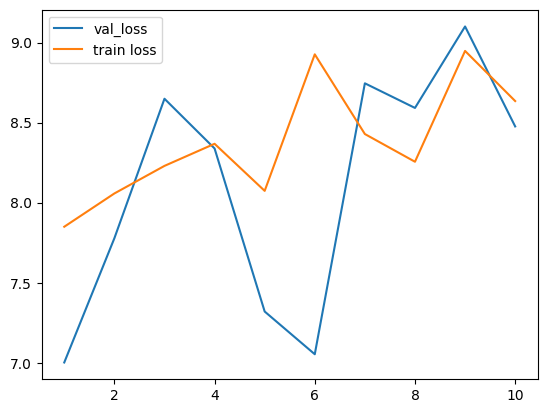

In [83]:
val_loss_q3 = history.history["val_categorical_crossentropy"]
train_loss_q3 = history.history["categorical_crossentropy"]
plt.plot(np.arange(1,len(val_loss_q3)+1),val_loss_q3, label="val_loss")
plt.plot(np.arange(1,len(train_loss_q3)+1),train_loss_q3, label="train loss")
plt.legend()

# Question 5 - Transfer Learning (20 points)
Transfer learning is the process of reusing a model trained for one task as a starting point for a model for another task. There are two ways of going about this - Feature Extraction and Fine Tuning

## Part (a) Feature Extraction (10 points)

You will create a base model from VGG16 that has been pretrained using the ImageNet data set. This data set is quite large (14 million images) with thousands of classes so it's safe to say that this pretrained model is pretty good. In feature extraction, we will freeze the layers that have been pretrained so the weights don't get updated. You can can read more about it [here](https://www.tensorflow.org/tutorials/images/transfer_learning) and [here](https://keras.io/guides/transfer_learning/#:~:text=trainable%20to%20False%20moves%20all,trainable_weights%20to%20apply%20gradient%20updates).



Like the previous question, use the following flowchart to fill in the ```FeatureExtracted```. ```data_aug``` will take the sequential model with the data augmentation and preprocessing layers. When using the VGG16 model, please remember to set ```include_top = False```

<img src='https://drive.google.com/uc?id=1aRy355STjBLBUmVH8FwzxcWeE6l5mSza' width = 700>

In [73]:
'''
class FeatureExtracted(keras.Model):
  def __init__(self, num_classes, input_shape, data_aug):
    super(FeatureExtracted, self).__init__()
    self.da = data_aug

  def call(self, x):
    output = self.da(x)
    ## Write your code here

    return output
'''
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers

class FeatureExtracted(keras.Model):
    def __init__(self, num_classes, input_shape, data_aug):
        super(FeatureExtracted, self).__init__()
        self.da = data_aug
        self.vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
        self.vgg16_base.trainable = False  # Freeze the base to prevent weights from being updated
        self.avg_pooling = layers.GlobalAveragePooling2D()
        self.dense = layers.Dense(num_classes, activation='softmax')

    def call(self, x):
        x = self.da(x)  # Apply data augmentation
        x = self.vgg16_base(x)  # Pass the input through the VGG16 base
        x = self.avg_pooling(x)  # Apply average pooling
        output = self.dense(x)  # Pass the result through the dense softmax layer
        return output



In [74]:
feature_extracted_model = FeatureExtracted(10, (32, 32, 3), data_aug_preprocess)
feature_extracted_model.compile(optimizer= "adam",
                     loss="categorical_crossentropy",
                     metrics=["categorical_crossentropy", "accuracy"])
history_2 = feature_extracted_model.fit(X_train, Y_train, batch_size = 256, steps_per_epoch = len(X_train) / 256, epochs = 10,
                 validation_data = (X_val, Y_val))

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
156/156 [==============================] - 12s 51ms/step - loss: 1.9682 - categorical_crossentropy: 1.9682 - accuracy: 0.3072 - val_loss: 1.7653 - val_categorical_crossentropy: 1.7653 - val_accuracy: 0.4038
Epoch 2/10
156/156 [==============================] - 6s 37ms/step - loss: 1.7050 - categorical_crossentropy: 1.7050 - accuracy: 0.4128 - val_loss: 1.6342 - val_categorical_crossentropy: 1.6342 - val_accuracy: 0.4436
Epoch 3/10
156/156 [==============================] - 6s 37ms/step - loss: 1.6244 - categorical_crossentropy: 1.6244 - accuracy: 0.4419 - val_loss: 1.5622 - val_categorical_crossentropy: 1.5622 - val_accuracy: 0.4663
Epoch 4/10
156/156 [==============================] - 6s 35ms/step - loss: 1.5791 - categorical_crossentropy: 1.5791 - accuracy: 0.4543 - val_loss: 1.5223 - val_categorical_crossentropy: 1.5223 - val_accuracy: 0.4783
Epoch 5/10
156/156 [==============================] - 6s 37ms/step

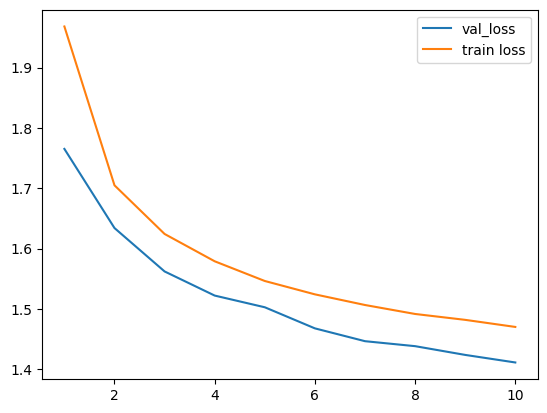

In [75]:
val_loss_q4a = history_2.history["val_categorical_crossentropy"]
train_loss_q4a = history_2.history["categorical_crossentropy"]
plt.plot(np.arange(1,len(val_loss_q4a)+1),val_loss_q4a, label="val_loss")
plt.plot(np.arange(1,len(train_loss_q4a)+1),train_loss_q4a, label="train loss")
plt.legend()

## Part (b) Finetuning (10 points)

In feature extraction, we only trained the output layer and we freezed the all the layers in the pretrained model. We can improve performance of the previous model by unfreezing some of the layers. It's important to perform finetuning after the model with the frozen layers has been trained because mixing layers with pretrained weights and the randomly initialized weights can cause the fitting procedure to take large gradient descent steps. We also want to have a lower learning rate for this algorithm to avoid a risk of overfitting.

For this question, let's keep the first 15 layers of vgg model from the previous part frozen and unfreeze the rest of the layers. Recompile the model using an Adam optimizer with a learning rate of 0.00001 and refit this model.

Please only make these changes to the variable ```feature_extracted_model``` from the previous part

You can can read more about it [here](https://www.tensorflow.org/tutorials/images/transfer_learning) and [here](https://keras.io/guides/transfer_learning/#:~:text=trainable%20to%20False%20moves%20all,trainable_weights%20to%20apply%20gradient%20updates).

In [88]:
'''
print(len(feature_extracted_model.trainable_variables))
## Write your code here


##
print(len(feature_extracted_model.trainable_variables))
history_3 = feature_extracted_model.fit(X_train, Y_train, batch_size = 256, steps_per_epoch = len(X_train) / 256, epochs = 10,
                 validation_data = (X_val, Y_val))
'''
# Check the number of trainable variables now
print(len(feature_extracted_model.trainable_variables))

# Recompile the model with a lower learning rate for fine-tuning
feature_extracted_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Now you can refit your model
history_3 = feature_extracted_model.fit(
    X_train, Y_train,
    batch_size=256,
    steps_per_epoch=len(X_train) / 256, epochs = 10,
    validation_data=(X_val, Y_val)
)

# After training, if you want to check the number of trainable variables again
print(len(feature_extracted_model.trainable_variables))


2
Epoch 1/10
156/156 [==============================] - 8s 40ms/step - loss: 1.4572 - accuracy: 0.4954 - val_loss: 1.4078 - val_accuracy: 0.5143
Epoch 2/10
156/156 [==============================] - 6s 37ms/step - loss: 1.4554 - accuracy: 0.4966 - val_loss: 1.4085 - val_accuracy: 0.5142
Epoch 3/10
156/156 [==============================] - 6s 39ms/step - loss: 1.4575 - accuracy: 0.4936 - val_loss: 1.4068 - val_accuracy: 0.5130
Epoch 4/10
156/156 [==============================] - 6s 38ms/step - loss: 1.4540 - accuracy: 0.4941 - val_loss: 1.4069 - val_accuracy: 0.5146
Epoch 5/10
156/156 [==============================] - 6s 39ms/step - loss: 1.4515 - accuracy: 0.4996 - val_loss: 1.4054 - val_accuracy: 0.5147
Epoch 6/10
156/156 [==============================] - 6s 36ms/step - loss: 1.4534 - accuracy: 0.4964 - val_loss: 1.4033 - val_accuracy: 0.5158
Epoch 7/10
156/156 [==============================] - 6s 38ms/step - loss: 1.4518 - accuracy: 0.4959 - val_loss: 1.4028 - val_accuracy: 0.51

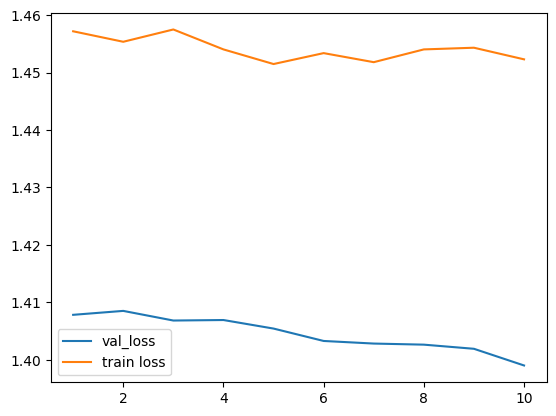

In [89]:
val_loss_q4b = history_3.history["val_loss"]
train_loss_q4b = history_3.history["loss"]
plt.plot(np.arange(1,len(val_loss_q4b)+1),val_loss_q4b, label="val_loss")
plt.plot(np.arange(1,len(train_loss_q4b)+1),train_loss_q4b, label="train loss")
plt.legend()